In [14]:
# Import necessary libraries
import numpy as np
from pandas import read_csv
import pandas as pd
import random
import torch
from sklearn.metrics import accuracy_score
import torch.optim as optim
import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt

# 1. Model

In [2]:
class Masking(nn.Module):
    def __init__(self, masked_value=-1):
        super(Masking, self).__init__()
        self.masked_value = masked_value
    
    def forward(self, lon_data_train):
        # The seq_lengths list is used to store the length of each sequence in the training data
        # used in the pack_padded_sequence function
        '''
        Input:
            lon_data_train: shape = (bs, time_steps, num_features), here it is (bs, 6, 20)
        Output:
            seq_lengths, list, len=bs, where each element in the list is the length of the sequence
        '''

        seq_lengths = []
        for i in range(len(lon_data_train)):
            for j in range(len(lon_data_train[i])):
                if torch.all(torch.eq(lon_data_train[i][j], self.masked_value)):
                    seq_lengths.append(j)
                    break
            if not torch.any(torch.eq(lon_data_train[i], self.masked_value)):
                seq_lengths.append(6)
        return seq_lengths
    

    
class GetLast(nn.Module):
    def __init__(self, last_idx=-1):
        super(GetLast, self).__init__()
        self.last_idx = last_idx
    
    def forward(self, x, seq_lengths):
        '''
        Input:
            x: tensor, shape = (bs, time_steps, num_features), here it is (bs, 6, 20)
            seq_lengths: list, len=bs, where each element in the list is the length of the sequence
        Output:
            batch_last: shape = (bs, num_features), where each element in the list is the last element of the sequence
        '''
        indices = torch.tensor(seq_lengths) + self.last_idx
        x = x[torch.arange(x.size(0)), indices]
        return x

class PPADWithDemographic(nn.Module):
    def __init__(self, cell, drout, num_features_in_each_time_step=20, demographic_features=14, masked_value=-1):
        super(PPADWithDemographic, self).__init__()

        self.masking = Masking(masked_value)
        self.get_last = GetLast(last_idx=-1)

        self.cell_type = cell
        self.drout = nn.Dropout(drout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() 

        rnn_hidden_size_1 = 16
        rnn_hidden_size_2 = 8
        if cell == 'GRU':
            self.rnn1 = nn.GRU(input_size=num_features_in_each_time_step, hidden_size=rnn_hidden_size_1, num_layers=1, batch_first=True)
            self.rnn2 = nn.GRU(input_size=rnn_hidden_size_1, hidden_size=rnn_hidden_size_2, num_layers=1, batch_first=True)
        elif cell == 'LSTM':
            self.rnn1 = nn.LSTM(input_size=num_features_in_each_time_step, hidden_size=rnn_hidden_size_1, num_layers=1, batch_first=True)
            self.rnn2 = nn.LSTM(input_size=rnn_hidden_size_1, hidden_size=rnn_hidden_size_2, num_layers=1, batch_first=True)
        elif cell == 'biGRU':
            self.rnn1 = nn.GRU(input_size=num_features_in_each_time_step, hidden_size=rnn_hidden_size_1, num_layers=1, batch_first=True, bidirectional=True)
            self.rnn2 = nn.GRU(input_size=rnn_hidden_size_1*2, hidden_size=rnn_hidden_size_2, num_layers=1, batch_first=True, bidirectional=True)
        elif cell == 'biLSTM':
            self.rnn1 = nn.LSTM(input_size=num_features_in_each_time_step, hidden_size=rnn_hidden_size_1, num_layers=1, batch_first=True, bidirectional=True)
            self.rnn2 = nn.LSTM(input_size=rnn_hidden_size_1*2, hidden_size=rnn_hidden_size_2, num_layers=1, batch_first=True, bidirectional=True)
        else:
            raise ValueError('Invalid cell type')
        
        rnn_output_size = rnn_hidden_size_2 * (2 if 'bi' in cell else 1)
        self.fc1 = nn.Linear(demographic_features + rnn_output_size, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x, demographic):
        # Mask the input
        seq_lengths = self.masking(x)
        
        # Process through RNNs
        x = self._process_rnn(x, seq_lengths)

        # Take the last valid output from the RNN
        x = self.get_last(x, seq_lengths)
        x = self.drout(x)

        # Combine with demographic features and pass through fully connected layers
        x = torch.cat((x, demographic), dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

    def _process_rnn(self, x, seq_lengths):
        x = nn.utils.rnn.pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
        x, _ = self.rnn1(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        x = self.drout(x)
        x = nn.utils.rnn.pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
        x, _ = self.rnn2(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        return x
    
# Example usage
# num_features_in_each_time_step = 20
# cell = 'GRU'
# drout = 0.2

# model = PPADWithDemographic(cell, drout, num_features_in_each_time_step)
# print(model.parameters)


# Global Variables

In [3]:
# unpikle data

# Longitudinal training data
file_name = './PPAD sample of dataset/longitudinal_data_train.pkl'
lon_data_train = pd.read_pickle(file_name)

# Labels of traing data 
file_name = './PPAD sample of dataset/label_train.pkl'
label_train = pd.read_pickle(file_name)

# Demographic training data
file_name = './PPAD sample of dataset/demographic_data_train.pkl'
dem_data_train = pd.read_pickle(file_name)

# Longitudinal test data
file_name = './PPAD sample of dataset/longitudinal_data_test.pkl'
lon_data_test = pd.read_pickle(file_name)

# Labels of test data 
file_name = './PPAD sample of dataset/label_test.pkl'
label_test = pd.read_pickle(file_name)

# Demographic test data
file_name = './PPAD sample of dataset/demographic_data_test.pkl'
dem_data_test = pd.read_pickle(file_name)

###########################################################

# This represents number of visits (time points) will be used in the training.
time_steps = lon_data_test[0].shape[1] # 6

# This represents number of future visits ahead to predict 
future_time_s = label_test[0].shape[1] # 1

# This represents how many featutes in each visit (longitudinal).
num_features_in_each_time_step = lon_data_test[0].shape[2] # 20

# This represents how many demographic featutes (cross sectional).
demographic_features = len(dem_data_test[0][0]) # 1


In [4]:

if future_time_s == 1:
    # dataset
    train_data_lon = torch.tensor(lon_data_train[0], dtype=torch.float32)
    train_data_dem = torch.tensor(dem_data_train[0], dtype=torch.float32)

    test_data_lon = torch.tensor(lon_data_test[0], dtype=torch.float32)
    test_data_dem = torch.tensor(dem_data_test[0], dtype=torch.float32)

    train_label = torch.tensor(label_train[0], dtype=torch.float32).squeeze(-1)
    test_label = torch.tensor(label_test[0], dtype=torch.float32).squeeze(-1)
    print(train_data_lon.shape, train_data_dem.shape, train_label.shape)

train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data_lon, train_data_dem, train_label), batch_size=8, shuffle=False   
)

test_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_data_lon, test_data_dem, test_label), batch_size=8, shuffle=False
)

for i, (lon_data_train_i, demographic_i, labels_i) in enumerate(train_dataloader):
    print(lon_data_train_i.shape, demographic_i.shape, labels_i.shape)
    break


torch.Size([807, 6, 20]) torch.Size([807, 14]) torch.Size([807, 1])
torch.Size([8, 6, 20]) torch.Size([8, 14]) torch.Size([8, 1])


# Train

In [6]:
# settings
learning_rate = 0.001
num_epochs = 50

# class binary_cross_entropy(nn.Module):
#     def __init__(self):
#         super(binary_cross_entropy, self).__init__()
    
#     def forward(self, y, yhat):
#         alpha = 0.5
#         loss = -torch.mean((alpha * y * torch.log(yhat + 1e-6)) + ((1.0 - alpha) * (1 - y) * torch.log(1 - yhat + 1e-6)))
#         return loss

# model
model = PPADWithDemographic(cell='GRU', drout=0)
device = 'cpu'
model.to(device)

criterion = nn.BCELoss()
# criterion = binary_cross_entropy()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train 
model.train()

losses = []
acces = []
accuracies = []
for epoch in tqdm.tqdm(range(num_epochs)):
    epoch_loss = 0
    epoch_acc = 0
    for i, (lon_data_train_i, demographic_i, labels_i) in enumerate(train_dataloader):
        lon_data_train_i = lon_data_train_i.to(device)
        demographic_i = demographic_i.to(device)
        labels_i = labels_i.to(device)  # Ensure labels are of shape (bs, 1)

        # 前向传播
        outputs = model(lon_data_train_i, demographic_i)

        loss = criterion(outputs, labels_i)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss and acc
        epoch_loss += loss.item()

        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                if outputs[i, j] > 0.5:
                    outputs[i, j] = 1
                else:
                    outputs[i, j] = 0

        epoch_acc += accuracy_score(outputs.detach().numpy(), labels_i)

    
    average_loss = epoch_loss / len(train_dataloader)
    average_acc = epoch_acc / len(train_dataloader)
    # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}, acc: {average_acc}')
    losses.append(average_loss)
    acces.append(average_acc)




100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


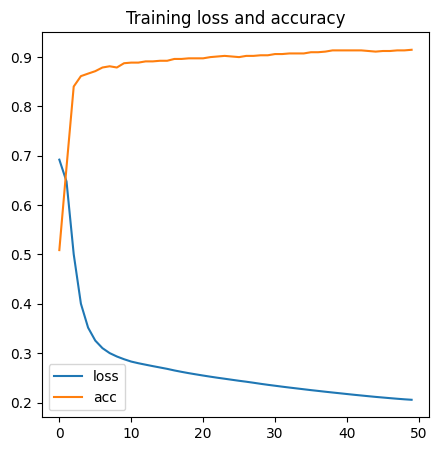

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(losses, label='loss')
plt.plot(acces, label='acc')
plt.legend()
plt.title('Training loss and accuracy')
plt.show()

In [16]:
# Test
model.eval()

loss_test = 0
acc_test = 0

with torch.no_grad():
    for i, (lon_data_train_i, demographic_i, labels_i) in enumerate(test_dataloader):
        lon_data_train_i = lon_data_train_i.to(device)
        demographic_i = demographic_i.to(device)
        labels_i = labels_i.to(device)  # Ensure labels are of shape (bs, 1)

        # 前向传播
        outputs = model(lon_data_train_i, demographic_i)

        loss = criterion(outputs, labels_i)


        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                if outputs[i, j] > 0.5:
                    outputs[i, j] = 1
                else:
                    outputs[i, j] = 0

        loss_test += loss.item()
        acc_test += accuracy_score(outputs.detach().numpy(), labels_i)
        

print(f'test loss : {loss_test / len(test_dataloader)}')
print(f'test acc : {acc_test / len(test_dataloader)}')
 


test loss : 0.28945171684026716
test acc : 0.8875
